In [1]:
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")

In [3]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from glob import glob
import numpy as np
from itertools import chain
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [4]:
from metaproteomics.file_processing.blazmass_tools import dta_select_parser, build_pep_quant_dict
from metaproteomics.goatools import obo_parser
goa = obo_parser.GODag()

load obo file /home/gstupp/projects/metaproteomics/metaproteomics/goatools/go-basic.obo
48437 nodes imported


In [5]:
files = glob("data/*/*.txt")

In [6]:
files

['data/Triflic/PA triflic 4.txt',
 'data/Triflic/PA triflic 3.txt',
 'data/Triflic/PA triflic 5.txt',
 'data/pellet triflic/PA pellet triflic 2.txt',
 'data/pellet triflic/PA pellet triflic 4.txt',
 'data/pellet triflic/PA pellet triflic 3.txt',
 'data/Sonic/PA sonic 1.txt',
 'data/Sonic/PA sonic 3.txt',
 'data/Sonic/PA sonic 4.txt']

In [7]:
df = pd.read_csv("annotations.mapped.gaf", sep="\t", comment="!", header=None)
df = df.rename(columns={1:"id", 4:"go_id", 8:'aspect'})
df = df.query("aspect == 'C'")
df = df.query("go_id != 'GO:0005575'")  # remove 'cellular component'
df.head(2)

,0,id,2,3,go_id,5,6,7,aspect,9,10,11,12,13,14,15,16
2,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0043234,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN
3,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0005622,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN


In [8]:
go_annot = df.groupby("id").agg({'go_id': lambda x: set(x)}).to_dict()['go_id']
go_annot['A0A024R161']

{'GO:0005622', 'GO:0005886', 'GO:0043234'}

In [9]:
print(', '.join({goa[x].name: x for x in set(df[df['aspect'] == 'C']['go_id'])}))

nuclear chromosome, vacuole, external encapsulating structure, cilium, cytoplasmic chromosome, nuclear envelope, extracellular region, nucleoplasm, cytoplasm, Golgi apparatus, cytoskeleton, organelle, plasma membrane, nucleus, cell wall, cytoplasmic vesicle, ribosome, mitochondrion, cell, intracellular, cytosol, extracellular space, thylakoid, nucleolus, microtubule organizing center, peroxisome, lysosome, proteinaceous extracellular matrix, endosome, protein complex, endoplasmic reticulum, chromosome, lipid particle


In [10]:
def get_proteins(loci):
    loci = [x for x in loci['loci'] if "|" in x['description']]
    for locus in loci:
        locus['uniprot'] = locus['description'].split("|")[1]
    return loci
locus = next(dta_select_parser(files[0], return_reverse=False))
get_proteins(locus)

[{'Descriptive Name': 'Probable peroxidase OS=Pseudomonas aeruginosa (strain ATCC 15692 / PAO1 / 1C / PRS 101 / LMG 12228) GN=PA3529 PE=4 SV=1 ',
  'EMPAI': 6.079458,
  'Length': 200,
  'Locus': 0,
  'MolWt': 21822,
  'NSAF': 0.013824832,
  'Sequence Count': 51,
  'Sequence Coverage': 0.85,
  'Spectrum Count': 325,
  'Validation Status': 'U',
  'description': 'tr|Q9HY81|Q9HY81_PSEAE',
  'pI': 5.6,
  'reverse': False,
  'uniprot': 'Q9HY81'}]

In [11]:
def get_go_count(file):
    """
    If a locus has multiple proteins, the go annotations for each protein are used and the spectral count assigned
    is divided by the number of proteins in the locus.
    If a protein has multiple go terms, the spectral count for that protein is divided by the number of GO terms
    """
    descr = dict()
    d = defaultdict(int)
    for locus in dta_select_parser(file, return_reverse=False):
        proteins = get_proteins(locus)
        for p in proteins:
            this_go = go_annot.get(p['uniprot'], [])
            descr[p['uniprot']] = {'go': ";".join(this_go), 'q': locus['quantification'], 
                          'go_name': ";".join([goa[x].name for x in this_go]), 
                          'name': p['Descriptive Name']}
            for go in this_go:
                d[go]+=(locus['quantification']/len(proteins))/len(this_go)
    d = dict(d)
    return d, descr

d,p = get_go_count(files[0])
d

{'GO:0005576': 276.3333333333333,
 'GO:0005615': 123.0,
 'GO:0005618': 37.16666666666667,
 'GO:0005622': 2051.6666666666665,
 'GO:0005623': 1671.4333333333332,
 'GO:0005634': 4.333333333333333,
 'GO:0005694': 62.916666666666664,
 'GO:0005730': 18.5,
 'GO:0005737': 6763.516666666667,
 'GO:0005739': 333.8333333333333,
 'GO:0005777': 4.0,
 'GO:0005829': 2388.266666666666,
 'GO:0005840': 798.8333333333336,
 'GO:0005886': 1984.8499999999997,
 'GO:0030312': 901.1666666666666,
 'GO:0043226': 104.99999999999999,
 'GO:0043234': 1471.1833333333334}

In [12]:
def get_membrane_count(d):
    # cell wall, plasma membrane
    membrane = {'GO:0005618', 'GO:0005886'}
    membrane_count = sum(count for go,count in d.items() if go in membrane)
    not_membrane_count = sum(count for go,count in d.items() if go not in membrane)
    return membrane_count, not_membrane_count

In [13]:
counts = dict()
all_counts = dict()
for file in tqdm(files):
    d,p = get_go_count(file)
    all_counts[file] = {goa[k].name:v for k,v in d.items()}
    membrane_count, not_membrane_count = get_membrane_count(d)
    counts[file] = (membrane_count, not_membrane_count, np.log(not_membrane_count/membrane_count))
    pd.DataFrame(p).T.to_csv(file + "_go_counts.csv")

100%|██████████| 9/9 [00:02<00:00,  4.65it/s]


In [14]:
df_out = pd.DataFrame({'files': list(counts.keys()),
 'membrane': [x[0] for x in counts.values()],
 'non-membrane': [x[1] for x in counts.values()],
 'ratio': [x[2] for x in counts.values()],
 'method': ["sonic" if "sonic" in file.lower() else "tri" for file in counts],
 'type': [file.split("/")[1] for file in counts]})
df_out = df_out.sort_values(["type", "method"])
df_out

,files,membrane,method,non-membrane,ratio,type
2,data/Sonic/PA sonic 3.txt,783.033333,sonic,19677.966667,3.224080,Sonic
5,data/Sonic/PA sonic 1.txt,947.700000,sonic,23975.300000,3.230741,Sonic
6,data/Sonic/PA sonic 4.txt,502.216667,sonic,13770.783333,3.311273,Sonic
1,data/Triflic/PA triflic 5.txt,1983.433333,tri,16527.566667,2.120200,Triflic
3,data/Triflic/PA triflic 3.txt,2181.566667,tri,16562.433333,2.027094,Triflic
8,data/Triflic/PA triflic 4.txt,2022.016667,tri,16973.983333,2.127586,Triflic
0,data/pellet triflic/PA pellet triflic 3.txt,4465.466667,tri,14729.533333,1.193481,pellet triflic
4,data/pellet triflic/PA pellet triflic 4.txt,4086.550000,tri,14027.450000,1.233315,pellet triflic
7,data/pellet triflic/PA pellet triflic 2.txt,5504.283333,tri,18435.716667,1.208763,pellet triflic


In [15]:
df_out.to_csv("df_out.csv")

In [16]:
%matplotlib inline

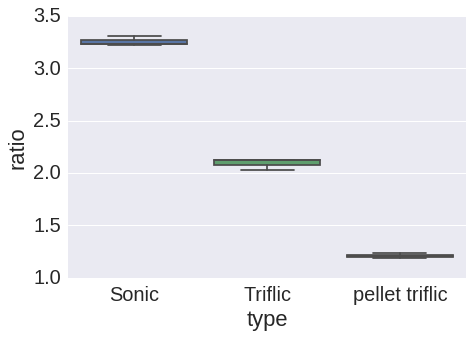

In [17]:
import seaborn as sns
sns.set(font_scale=2)
g = sns.factorplot(x="type", y="ratio", data=df_out, kind="box")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

In [18]:
all_counts = pd.DataFrame(all_counts)
all_counts

,data/Sonic/PA sonic 1.txt,data/Sonic/PA sonic 3.txt,data/Sonic/PA sonic 4.txt,data/Triflic/PA triflic 3.txt,data/Triflic/PA triflic 4.txt,data/Triflic/PA triflic 5.txt,data/pellet triflic/PA pellet triflic 2.txt,data/pellet triflic/PA pellet triflic 3.txt,data/pellet triflic/PA pellet triflic 4.txt
cell,3821.533333,3443.033333,1590.883333,1434.816667,1671.433333,1257.350000,1685.866667,1467.550000,1201.966667
cell wall,32.833333,32.333333,14.666667,40.666667,37.166667,32.833333,51.666667,47.000000,40.333333
chromosome,57.000000,126.666667,10.750000,21.750000,62.916667,22.500000,20.250000,21.750000,17.000000
cytoplasm,9189.866667,7703.700000,5274.300000,5984.733333,6763.516667,6296.850000,5143.450000,3875.883333,4268.050000
cytosol,3259.200000,2950.366667,2116.716667,2716.150000,2388.266667,2727.683333,2085.866667,1756.966667,1593.383333
external encapsulating structure,95.000000,42.666667,49.166667,1210.416667,901.166667,927.500000,3662.666667,3017.250000,2433.250000
extracellular region,364.833333,249.833333,391.083333,130.500000,276.333333,207.416667,140.333333,109.000000,124.750000
extracellular space,362.500000,242.000000,234.500000,71.333333,123.000000,126.000000,79.166667,65.500000,105.500000
intracellular,3338.833333,2440.666667,1881.500000,2064.750000,2051.666667,2120.666667,1954.833333,1607.833333,1825.500000
mitochondrion,694.666667,371.000000,483.166667,624.166667,333.833333,586.500000,891.333333,534.500000,233.000000


In [19]:
show = ['cell wall'] + list(all_counts.sum(axis=1).sort_values()[-9:].index) + ['other']
all_counts2 = all_counts[all_counts.index.isin(show)].T
other = all_counts[~all_counts.index.isin(show)].sum()
all_counts2['other'] = other

In [20]:
print(show)

['cell wall', 'mitochondrion', 'ribosome', 'external encapsulating structure', 'protein complex', 'cell', 'intracellular', 'cytosol', 'plasma membrane', 'cytoplasm', 'other']


In [21]:
all_counts2.index = all_counts2.index.map(lambda x:x.split("/")[-1].split(".")[0])

In [22]:
all_counts2[show]

,cell wall,mitochondrion,ribosome,external encapsulating structure,protein complex,cell,intracellular,cytosol,plasma membrane,cytoplasm,other
PA sonic 1,32.833333,694.666667,1136.000000,95.000000,1419.033333,3821.533333,3338.833333,3259.200000,914.866667,9189.866667,1021.166667
PA sonic 3,32.333333,371.000000,943.833333,42.666667,977.200000,3443.033333,2440.666667,2950.366667,750.700000,7703.700000,805.500000
PA sonic 4,14.666667,483.166667,492.333333,49.166667,970.216667,1590.883333,1881.500000,2116.716667,487.550000,5274.300000,912.500000
PA triflic 3,40.666667,624.166667,897.500000,1210.416667,1328.650000,1434.816667,2064.750000,2716.150000,2140.900000,5984.733333,301.250000
PA triflic 4,37.166667,333.833333,798.833333,901.166667,1471.183333,1671.433333,2051.666667,2388.266667,1984.850000,6763.516667,594.083333
PA triflic 5,32.833333,586.500000,763.333333,927.500000,1379.933333,1257.350000,2120.666667,2727.683333,1950.600000,6296.850000,467.750000
PA pellet triflic 2,51.666667,891.333333,503.000000,3662.666667,2225.116667,1685.866667,1954.833333,2085.866667,5452.616667,5143.450000,283.583333
PA pellet triflic 3,47.000000,534.500000,441.333333,3017.250000,1799.633333,1467.550000,1607.833333,1756.966667,4418.466667,3875.883333,228.583333
PA pellet triflic 4,40.333333,233.000000,436.666667,2433.250000,1748.883333,1201.966667,1825.500000,1593.383333,4046.216667,4268.050000,286.750000


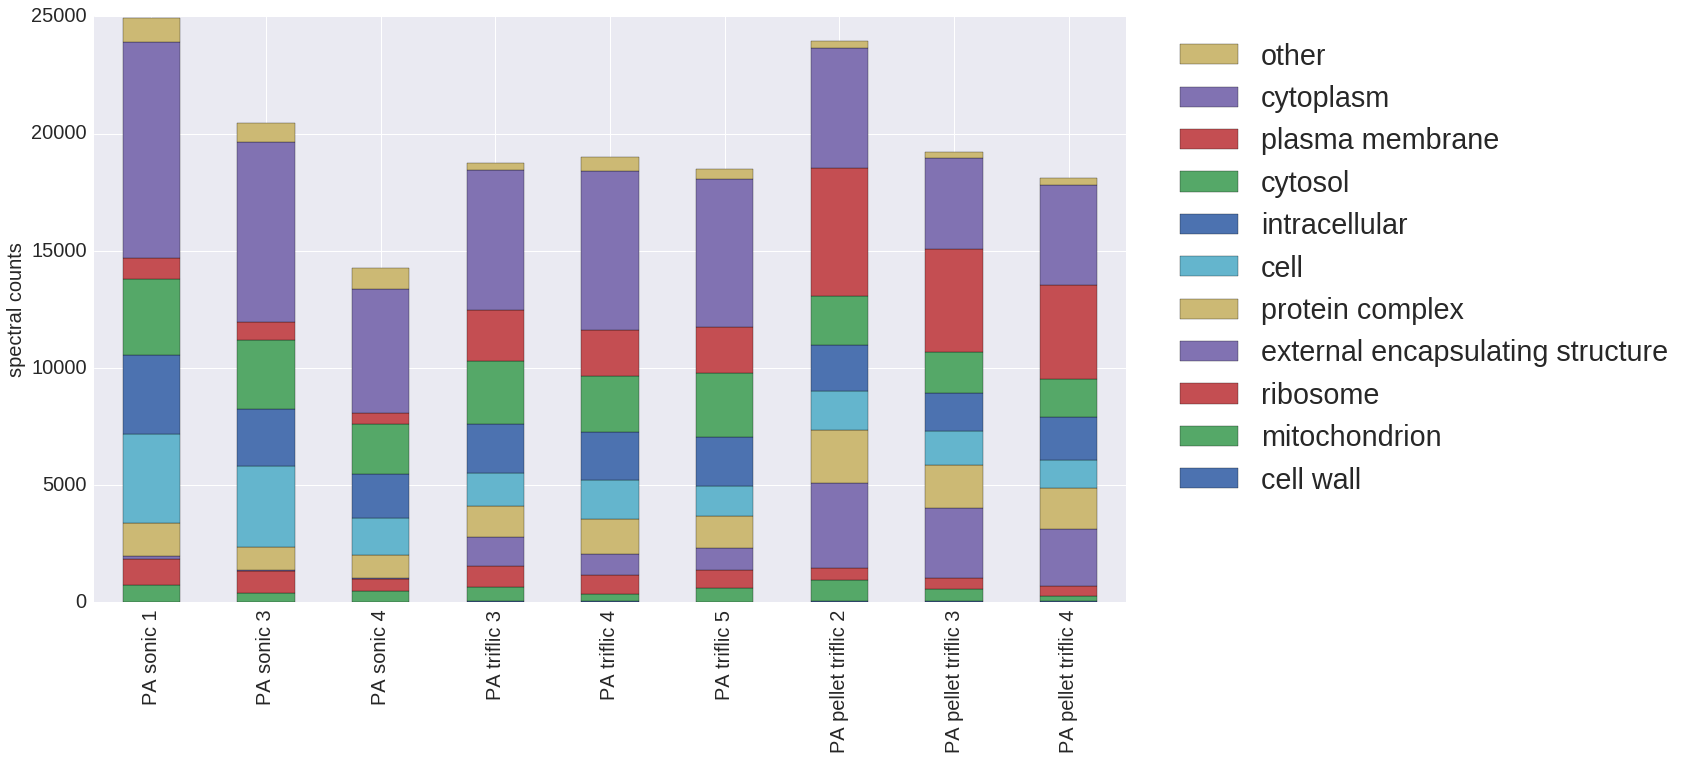

In [23]:
ax = all_counts2[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.55, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

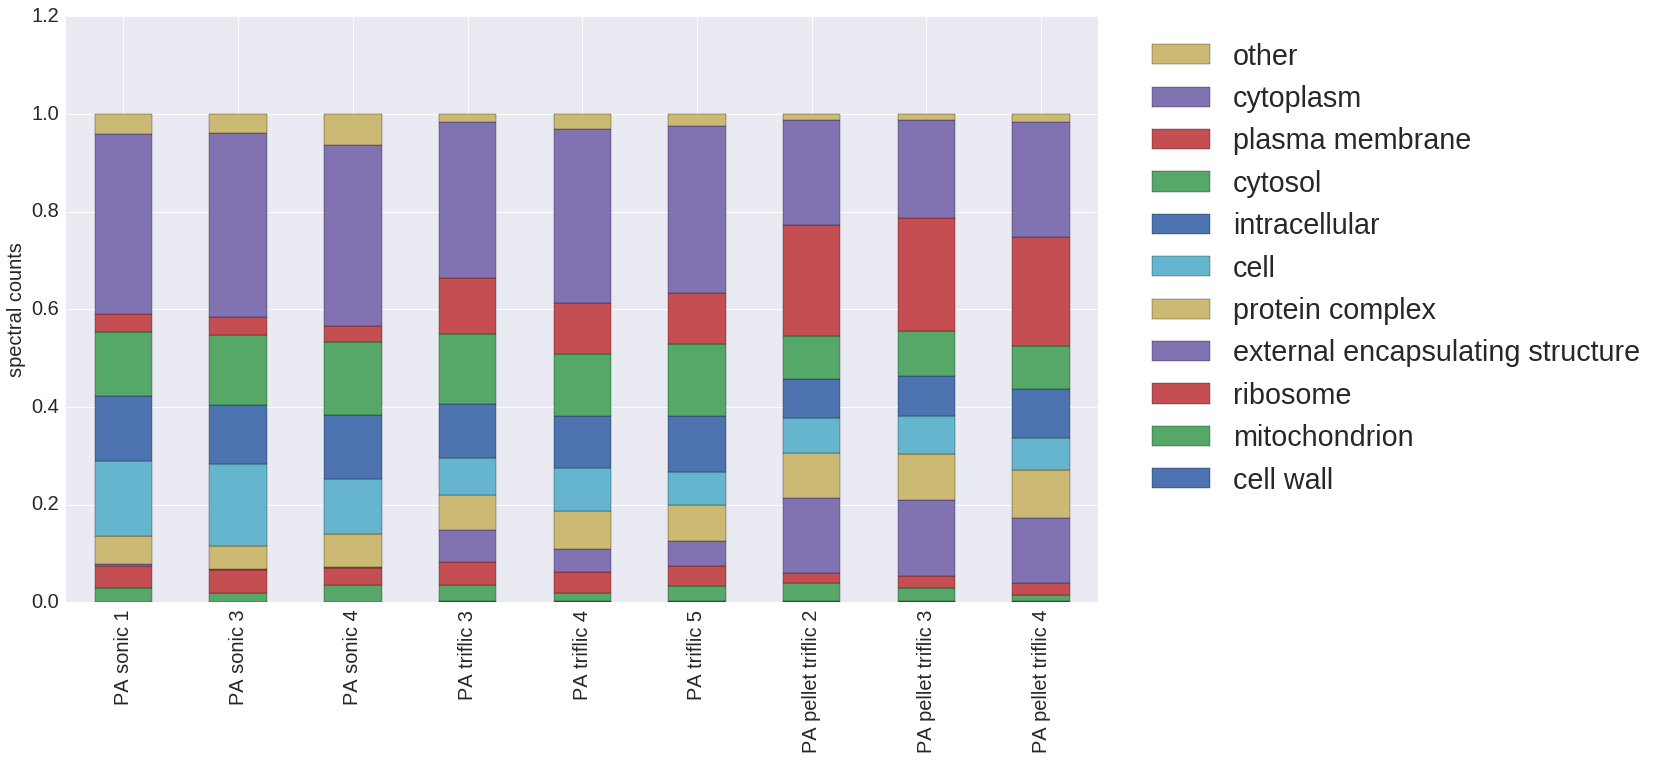

In [24]:
ax = all_counts2.div(all_counts2.sum(1), axis=0)[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.55, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [25]:
df = all_counts2.T
gs = ["PA sonic", "PA triflic", "PA pellet triflic"]
for g in gs:
    df[g] = df[df.columns[df.columns.str.contains(g)]].sum(1)
df = df[gs]
df3 = df.T

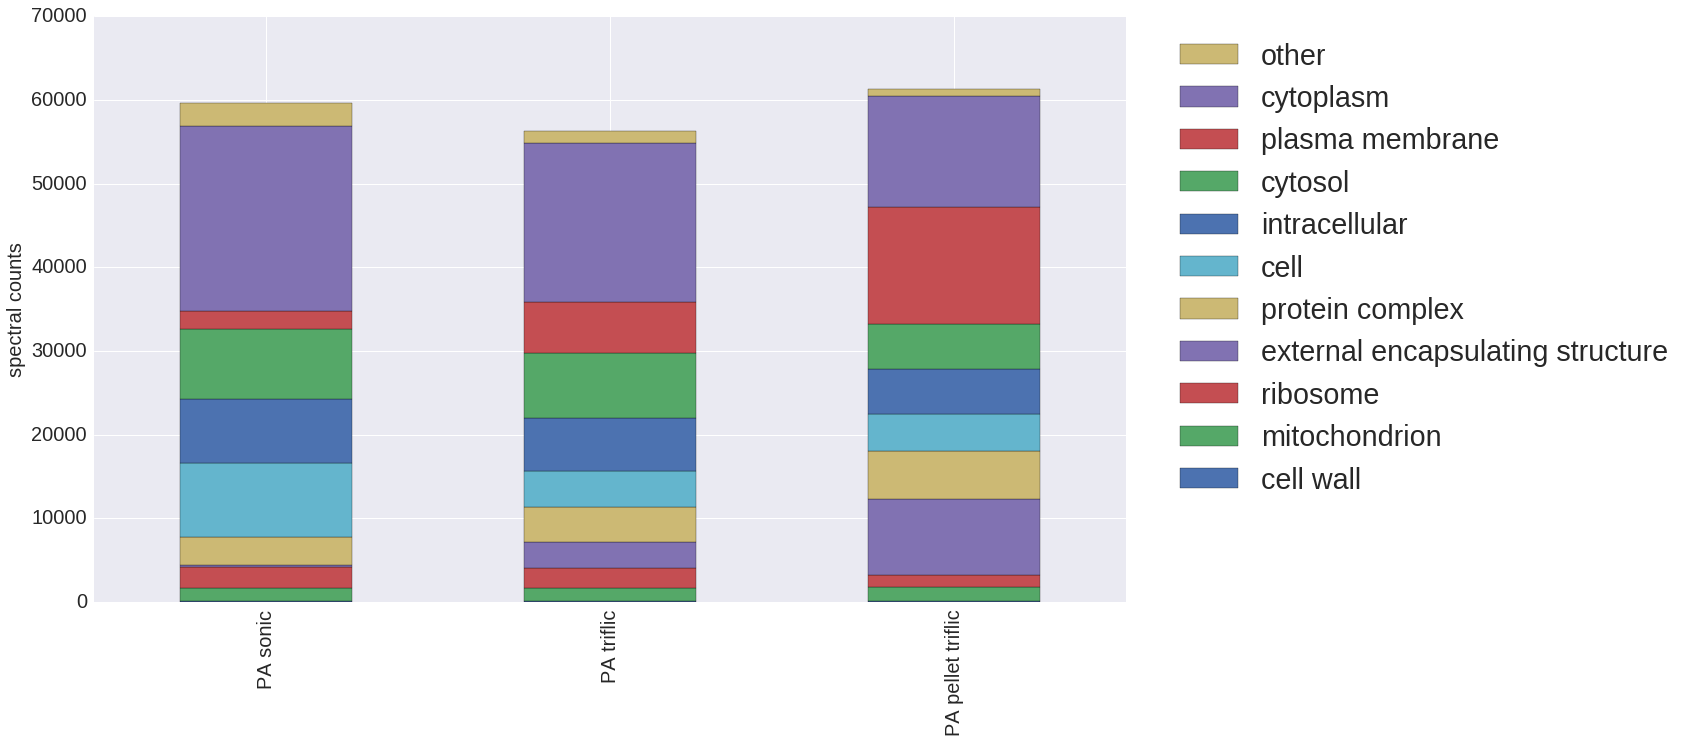

In [26]:
ax = df3[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.55, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

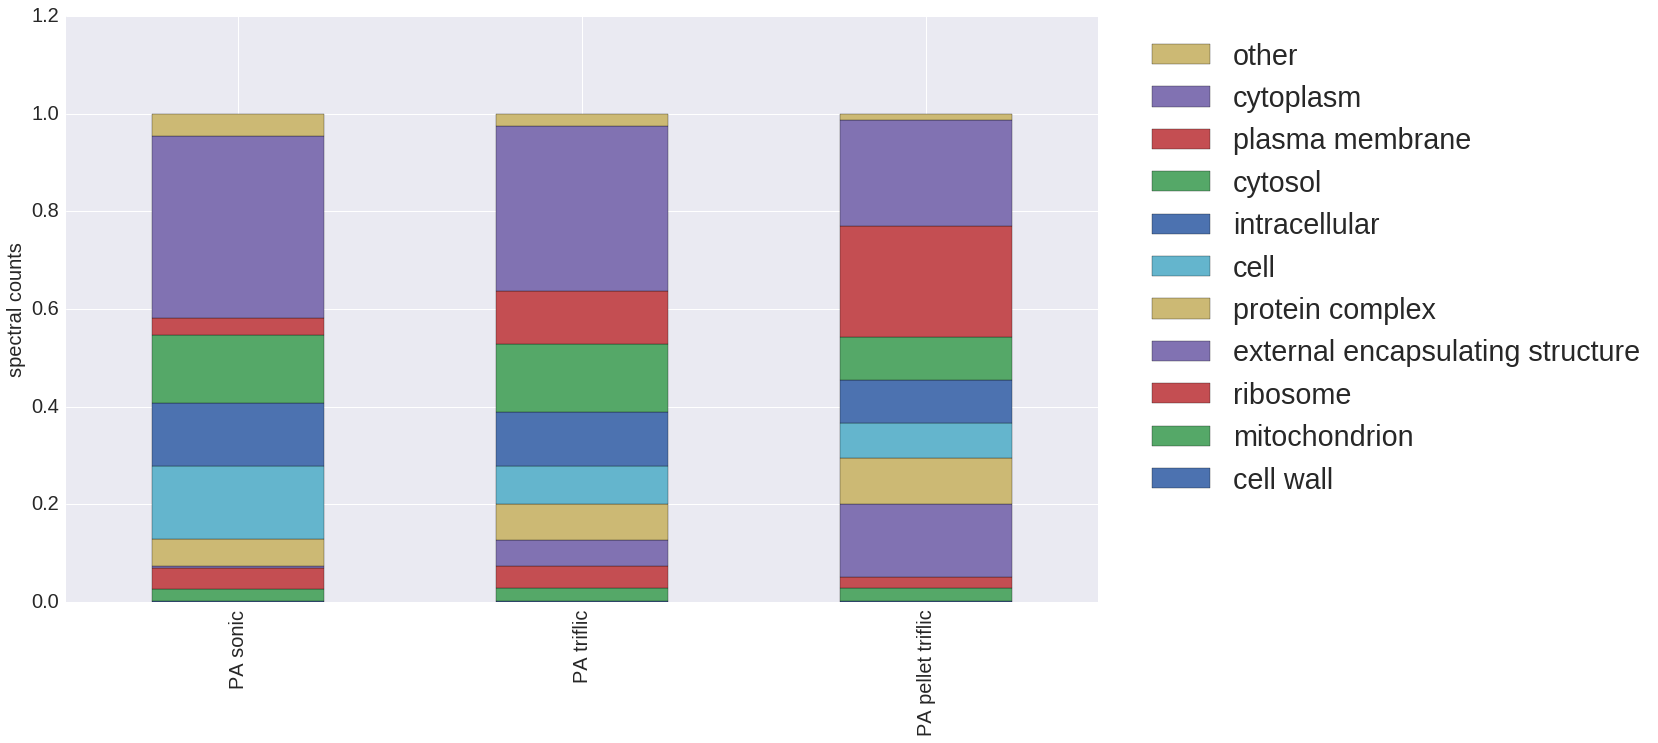

In [27]:
ax = df3.div(df3.sum(1), axis=0)[show].plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.55, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

In [ ]:
## not used
## yates style normalization
# normalize all samples to the sum of the spectral counts of the 500 most abundant peptides in at least half or more of samples
sample_pep_quant = {f:build_pep_quant_dict(dta_select_parser(f), field='Redundancy') for f in files}
toppep = dict()
for sample,pep_quant in sample_pep_quant.items():
    toppep[sample],_ = zip(*sorted(pep_quant.items(),key=lambda x:x[1])[-500:])
sample_count = Counter(chain(*toppep.values()))
common_pep = {pep for pep,count in sample_count.items() if count>=round(len(files)/2)} #half of the the samples
s=Counter()
for pep in common_pep:
    s.update({sample:sample_pep_quant[sample].get(pep,0) for sample in sample_pep_quant})
nfs = {sample:value/np.mean(list(s.values())) for sample, value in s.items()}
nfs